In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    Resized,
    RandAffined,
    RandRotate90d,
    RandZoomd,
    RandFlipd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet, UNETR
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np
from tqdm.notebook import tqdm

In [2]:
data_dir = "Task06_Lung/"

train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))

data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-13], data_dicts[-13:]

print(f"length of train_files: {len(train_files)}, val_files: {len(val_files)}")

length of train_files: 50, val_files: 13


In [3]:
set_determinism(seed=42)

In [4]:
"""
# Find intensity value range from train dataset
import nibabel as nib
def find_min_max_intensity_nifti(dataset_path):
    min_intensity = float('inf')
    max_intensity = float('-inf')

    # Assuming MRI images are stored as NIfTI files (.nii or .nii.gz)
    for file_name in os.listdir(dataset_path):
        if file_name.endswith('.nii') or file_name.endswith('.nii.gz'):
            file_path = os.path.join(dataset_path, file_name)
            
            # Load the MRI image using NiBabel
            img = nib.load(file_path)
            data = img.get_fdata()

            # Find the min and max intensity values in the image
            current_min = data.min()
            current_max = data.max()

            # Update overall min and max intensity values
            min_intensity = min(min_intensity, current_min)
            max_intensity = max(max_intensity, current_max)

    return min_intensity, max_intensity

# Replace 'your_dataset_path' with the actual path to your NIfTI dataset
nifti_dataset_path = 'Task02_Heart/imagesTr'
min_intensity_nifti, max_intensity_nifti = find_min_max_intensity_nifti(nifti_dataset_path)

print(f"Minimum intensity: {min_intensity_nifti}")
print(f"Maximum intensity: {max_intensity_nifti}")
"""

""""""

''

In [5]:
train_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=1.0, spatial_size=(96, 96, 96),
            rotate_range=(0, 0, np.pi/15),
            scale_range=(0.1, 0.1, 0.1)
        ),
        #RandRotate90d(keys=['image', 'label'], prob=0.5),
        #RandZoomd(keys=['image', 'label'], min_zoom=0.9, max_zoom=1.1, prob=0.5),
        #RandFlipd(keys=['image', 'label'], prob=0.5)
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.


image shape: torch.Size([214, 203, 185]), label shape: torch.Size([214, 203, 185])


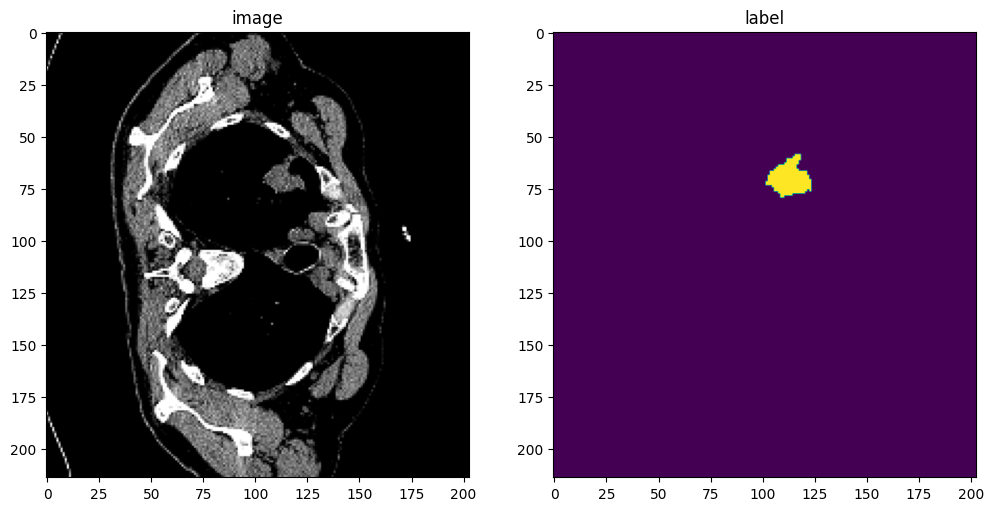

In [6]:
# Check dataset

view_ds = Dataset(data=val_files, transform=val_transform)
view_loader = DataLoader(view_ds, batch_size=1)

view_data = first(view_loader)

image, label = (view_data["image"][0][0], view_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")

view_slice = 150

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, view_slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, view_slice])
plt.show()


In [7]:
train_ds = CacheDataset(data=train_files, transform=train_transform, cache_rate=1.0, num_workers=12)
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=12)

val_ds = CacheDataset(data=val_files, transform=val_transform, cache_rate=1.0, num_workers=12)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=12)

Loading dataset: 100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
"""
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

"""

model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256, 512),
    strides=(2, 2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.INSTANCE,
).to(device)

loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=True, reduction="mean")

In [9]:
num_epochs = 1000
val_interval = 5
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

for epoch in range(num_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{num_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in tqdm(train_loader):
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        #print(inputs.shape)
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        #print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_images, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_images, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]

                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            dice_metric.reset()
            metric_values.append(metric)
            
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), "best_metric_model.pth")
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 1 average loss: 1.2840
----------
epoch 2/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 2 average loss: 1.1935
----------
epoch 3/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 3 average loss: 1.1361
----------
epoch 4/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 4 average loss: 1.0824
----------
epoch 5/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 5 average loss: 1.0283
saved new best metric model
current epoch: 5 current mean dice: 0.4987
best mean dice: 0.4987 at epoch: 5
----------
epoch 6/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 6 average loss: 0.9823
----------
epoch 7/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 7 average loss: 0.9414
----------
epoch 8/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 8 average loss: 0.9039
----------
epoch 9/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 9 average loss: 0.8706
----------
epoch 10/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 10 average loss: 0.8405
saved new best metric model
current epoch: 10 current mean dice: 0.4999
best mean dice: 0.4999 at epoch: 10
----------
epoch 11/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 11 average loss: 0.8133
----------
epoch 12/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 12 average loss: 0.7898
----------
epoch 13/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 13 average loss: 0.7670
----------
epoch 14/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 14 average loss: 0.7464
----------
epoch 15/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 15 average loss: 0.7288
saved new best metric model
current epoch: 15 current mean dice: 0.5005
best mean dice: 0.5005 at epoch: 15
----------
epoch 16/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 16 average loss: 0.7109
----------
epoch 17/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 17 average loss: 0.6972
----------
epoch 18/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 18 average loss: 0.6839
----------
epoch 19/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 19 average loss: 0.6718
----------
epoch 20/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 20 average loss: 0.6572
current epoch: 20 current mean dice: 0.5001
best mean dice: 0.5005 at epoch: 15
----------
epoch 21/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 21 average loss: 0.6490
----------
epoch 22/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 22 average loss: 0.6377
----------
epoch 23/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 23 average loss: 0.6270
----------
epoch 24/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 24 average loss: 0.6183
----------
epoch 25/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 25 average loss: 0.6115
saved new best metric model
current epoch: 25 current mean dice: 0.5276
best mean dice: 0.5276 at epoch: 25
----------
epoch 26/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 26 average loss: 0.6050
----------
epoch 27/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 27 average loss: 0.6018
----------
epoch 28/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 28 average loss: 0.5888
----------
epoch 29/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 29 average loss: 0.5871
----------
epoch 30/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 30 average loss: 0.5795
current epoch: 30 current mean dice: 0.5211
best mean dice: 0.5276 at epoch: 25
----------
epoch 31/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 31 average loss: 0.5670
----------
epoch 32/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 32 average loss: 0.5649
----------
epoch 33/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 33 average loss: 0.5636
----------
epoch 34/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 34 average loss: 0.5552
----------
epoch 35/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 35 average loss: 0.5545
saved new best metric model
current epoch: 35 current mean dice: 0.5318
best mean dice: 0.5318 at epoch: 35
----------
epoch 36/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 36 average loss: 0.5506
----------
epoch 37/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 37 average loss: 0.5429
----------
epoch 38/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 38 average loss: 0.5349
----------
epoch 39/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 39 average loss: 0.5326
----------
epoch 40/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 40 average loss: 0.5298
current epoch: 40 current mean dice: 0.5203
best mean dice: 0.5318 at epoch: 35
----------
epoch 41/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 41 average loss: 0.5315
----------
epoch 42/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 42 average loss: 0.5227
----------
epoch 43/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 43 average loss: 0.5182
----------
epoch 44/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 44 average loss: 0.5122
----------
epoch 45/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 45 average loss: 0.5142
saved new best metric model
current epoch: 45 current mean dice: 0.5605
best mean dice: 0.5605 at epoch: 45
----------
epoch 46/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 46 average loss: 0.5098
----------
epoch 47/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 47 average loss: 0.5055
----------
epoch 48/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 48 average loss: 0.5054
----------
epoch 49/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 49 average loss: 0.5107
----------
epoch 50/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 50 average loss: 0.4980
current epoch: 50 current mean dice: 0.5550
best mean dice: 0.5605 at epoch: 45
----------
epoch 51/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 51 average loss: 0.5027
----------
epoch 52/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 52 average loss: 0.4909
----------
epoch 53/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 53 average loss: 0.4882
----------
epoch 54/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 54 average loss: 0.4872
----------
epoch 55/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 55 average loss: 0.4887
saved new best metric model
current epoch: 55 current mean dice: 0.5683
best mean dice: 0.5683 at epoch: 55
----------
epoch 56/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 56 average loss: 0.4798
----------
epoch 57/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 57 average loss: 0.4791
----------
epoch 58/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 58 average loss: 0.4751
----------
epoch 59/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 59 average loss: 0.4799
----------
epoch 60/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 60 average loss: 0.4682
saved new best metric model
current epoch: 60 current mean dice: 0.5722
best mean dice: 0.5722 at epoch: 60
----------
epoch 61/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 61 average loss: 0.4766
----------
epoch 62/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 62 average loss: 0.4763
----------
epoch 63/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 63 average loss: 0.4787
----------
epoch 64/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 64 average loss: 0.4623
----------
epoch 65/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 65 average loss: 0.4692
current epoch: 65 current mean dice: 0.5645
best mean dice: 0.5722 at epoch: 60
----------
epoch 66/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 66 average loss: 0.4556
----------
epoch 67/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 67 average loss: 0.4526
----------
epoch 68/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 68 average loss: 0.4595
----------
epoch 69/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 69 average loss: 0.4463
----------
epoch 70/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 70 average loss: 0.4535
saved new best metric model
current epoch: 70 current mean dice: 0.5831
best mean dice: 0.5831 at epoch: 70
----------
epoch 71/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 71 average loss: 0.4525
----------
epoch 72/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 72 average loss: 0.4380
----------
epoch 73/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 73 average loss: 0.4403
----------
epoch 74/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 74 average loss: 0.4417
----------
epoch 75/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 75 average loss: 0.4346
saved new best metric model
current epoch: 75 current mean dice: 0.5832
best mean dice: 0.5832 at epoch: 75
----------
epoch 76/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 76 average loss: 0.4418
----------
epoch 77/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 77 average loss: 0.4282
----------
epoch 78/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 78 average loss: 0.4378
----------
epoch 79/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 79 average loss: 0.4288
----------
epoch 80/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 80 average loss: 0.4200
saved new best metric model
current epoch: 80 current mean dice: 0.5964
best mean dice: 0.5964 at epoch: 80
----------
epoch 81/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 81 average loss: 0.4103
----------
epoch 82/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 82 average loss: 0.4281
----------
epoch 83/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 83 average loss: 0.4213
----------
epoch 84/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 84 average loss: 0.4183
----------
epoch 85/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 85 average loss: 0.4107
saved new best metric model
current epoch: 85 current mean dice: 0.6011
best mean dice: 0.6011 at epoch: 85
----------
epoch 86/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 86 average loss: 0.4104
----------
epoch 87/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 87 average loss: 0.4135
----------
epoch 88/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 88 average loss: 0.4095
----------
epoch 89/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 89 average loss: 0.4110
----------
epoch 90/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 90 average loss: 0.3983
current epoch: 90 current mean dice: 0.5706
best mean dice: 0.6011 at epoch: 85
----------
epoch 91/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 91 average loss: 0.3967
----------
epoch 92/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 92 average loss: 0.3975
----------
epoch 93/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 93 average loss: 0.3980
----------
epoch 94/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 94 average loss: 0.3926
----------
epoch 95/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 95 average loss: 0.4116
current epoch: 95 current mean dice: 0.5831
best mean dice: 0.6011 at epoch: 85
----------
epoch 96/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 96 average loss: 0.3932
----------
epoch 97/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 97 average loss: 0.3824
----------
epoch 98/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 98 average loss: 0.3834
----------
epoch 99/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 99 average loss: 0.3922
----------
epoch 100/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 100 average loss: 0.3905
current epoch: 100 current mean dice: 0.5769
best mean dice: 0.6011 at epoch: 85
----------
epoch 101/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 101 average loss: 0.3967
----------
epoch 102/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 102 average loss: 0.3847
----------
epoch 103/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 103 average loss: 0.3772
----------
epoch 104/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 104 average loss: 0.3766
----------
epoch 105/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 105 average loss: 0.3634
saved new best metric model
current epoch: 105 current mean dice: 0.6031
best mean dice: 0.6031 at epoch: 105
----------
epoch 106/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 106 average loss: 0.3522
----------
epoch 107/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 107 average loss: 0.3593
----------
epoch 108/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 108 average loss: 0.3665
----------
epoch 109/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 109 average loss: 0.3513
----------
epoch 110/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 110 average loss: 0.3605
current epoch: 110 current mean dice: 0.5998
best mean dice: 0.6031 at epoch: 105
----------
epoch 111/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 111 average loss: 0.3512
----------
epoch 112/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 112 average loss: 0.3332
----------
epoch 113/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 113 average loss: 0.3591
----------
epoch 114/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 114 average loss: 0.3694
----------
epoch 115/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 115 average loss: 0.3482
saved new best metric model
current epoch: 115 current mean dice: 0.6356
best mean dice: 0.6356 at epoch: 115
----------
epoch 116/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 116 average loss: 0.3544
----------
epoch 117/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 117 average loss: 0.3429
----------
epoch 118/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 118 average loss: 0.3452
----------
epoch 119/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 119 average loss: 0.3382
----------
epoch 120/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 120 average loss: 0.3307
current epoch: 120 current mean dice: 0.6136
best mean dice: 0.6356 at epoch: 115
----------
epoch 121/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 121 average loss: 0.3335
----------
epoch 122/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 122 average loss: 0.3280
----------
epoch 123/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 123 average loss: 0.3254
----------
epoch 124/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 124 average loss: 0.3343
----------
epoch 125/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 125 average loss: 0.3246
current epoch: 125 current mean dice: 0.6101
best mean dice: 0.6356 at epoch: 115
----------
epoch 126/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 126 average loss: 0.3286
----------
epoch 127/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 127 average loss: 0.3102
----------
epoch 128/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 128 average loss: 0.3270
----------
epoch 129/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 129 average loss: 0.3311
----------
epoch 130/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 130 average loss: 0.3281
current epoch: 130 current mean dice: 0.6195
best mean dice: 0.6356 at epoch: 115
----------
epoch 131/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 131 average loss: 0.3212
----------
epoch 132/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 132 average loss: 0.3434
----------
epoch 133/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 133 average loss: 0.3105
----------
epoch 134/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 134 average loss: 0.3046
----------
epoch 135/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 135 average loss: 0.3242
current epoch: 135 current mean dice: 0.6075
best mean dice: 0.6356 at epoch: 115
----------
epoch 136/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 136 average loss: 0.3208
----------
epoch 137/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 137 average loss: 0.3145
----------
epoch 138/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 138 average loss: 0.3068
----------
epoch 139/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 139 average loss: 0.3048
----------
epoch 140/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 140 average loss: 0.3196
current epoch: 140 current mean dice: 0.6051
best mean dice: 0.6356 at epoch: 115
----------
epoch 141/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 141 average loss: 0.3191
----------
epoch 142/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 142 average loss: 0.3111
----------
epoch 143/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 143 average loss: 0.3019
----------
epoch 144/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 144 average loss: 0.3012
----------
epoch 145/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 145 average loss: 0.2992
current epoch: 145 current mean dice: 0.6101
best mean dice: 0.6356 at epoch: 115
----------
epoch 146/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 146 average loss: 0.2846
----------
epoch 147/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 147 average loss: 0.3145
----------
epoch 148/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 148 average loss: 0.3141
----------
epoch 149/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 149 average loss: 0.2908
----------
epoch 150/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 150 average loss: 0.2926
saved new best metric model
current epoch: 150 current mean dice: 0.6537
best mean dice: 0.6537 at epoch: 150
----------
epoch 151/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 151 average loss: 0.2847
----------
epoch 152/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 152 average loss: 0.3015
----------
epoch 153/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 153 average loss: 0.3110
----------
epoch 154/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 154 average loss: 0.2914
----------
epoch 155/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 155 average loss: 0.3104
current epoch: 155 current mean dice: 0.6258
best mean dice: 0.6537 at epoch: 150
----------
epoch 156/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 156 average loss: 0.3080
----------
epoch 157/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 157 average loss: 0.3025
----------
epoch 158/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 158 average loss: 0.2796
----------
epoch 159/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 159 average loss: 0.2946
----------
epoch 160/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 160 average loss: 0.2856
current epoch: 160 current mean dice: 0.6176
best mean dice: 0.6537 at epoch: 150
----------
epoch 161/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 161 average loss: 0.2976
----------
epoch 162/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 162 average loss: 0.2934
----------
epoch 163/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 163 average loss: 0.2684
----------
epoch 164/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 164 average loss: 0.2963
----------
epoch 165/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 165 average loss: 0.3028
current epoch: 165 current mean dice: 0.6138
best mean dice: 0.6537 at epoch: 150
----------
epoch 166/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 166 average loss: 0.2953
----------
epoch 167/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 167 average loss: 0.3020
----------
epoch 168/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 168 average loss: 0.2986
----------
epoch 169/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 169 average loss: 0.3118
----------
epoch 170/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 170 average loss: 0.2897
current epoch: 170 current mean dice: 0.6038
best mean dice: 0.6537 at epoch: 150
----------
epoch 171/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 171 average loss: 0.2892
----------
epoch 172/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 172 average loss: 0.2955
----------
epoch 173/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 173 average loss: 0.3267
----------
epoch 174/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 174 average loss: 0.2913
----------
epoch 175/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 175 average loss: 0.2663
current epoch: 175 current mean dice: 0.6323
best mean dice: 0.6537 at epoch: 150
----------
epoch 176/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 176 average loss: 0.2722
----------
epoch 177/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 177 average loss: 0.3046
----------
epoch 178/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 178 average loss: 0.2862
----------
epoch 179/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 179 average loss: 0.2866
----------
epoch 180/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 180 average loss: 0.2798
current epoch: 180 current mean dice: 0.5740
best mean dice: 0.6537 at epoch: 150
----------
epoch 181/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 181 average loss: 0.3093
----------
epoch 182/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 182 average loss: 0.2797
----------
epoch 183/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 183 average loss: 0.3008
----------
epoch 184/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 184 average loss: 0.2890
----------
epoch 185/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 185 average loss: 0.2764
current epoch: 185 current mean dice: 0.5930
best mean dice: 0.6537 at epoch: 150
----------
epoch 186/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 186 average loss: 0.2874
----------
epoch 187/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 187 average loss: 0.2765
----------
epoch 188/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 188 average loss: 0.2907
----------
epoch 189/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 189 average loss: 0.2688
----------
epoch 190/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 190 average loss: 0.2956
current epoch: 190 current mean dice: 0.5811
best mean dice: 0.6537 at epoch: 150
----------
epoch 191/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 191 average loss: 0.2695
----------
epoch 192/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 192 average loss: 0.2880
----------
epoch 193/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 193 average loss: 0.2690
----------
epoch 194/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 194 average loss: 0.2720
----------
epoch 195/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 195 average loss: 0.2829
current epoch: 195 current mean dice: 0.6087
best mean dice: 0.6537 at epoch: 150
----------
epoch 196/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 196 average loss: 0.2731
----------
epoch 197/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 197 average loss: 0.2666
----------
epoch 198/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 198 average loss: 0.2572
----------
epoch 199/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 199 average loss: 0.2664
----------
epoch 200/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 200 average loss: 0.2823
current epoch: 200 current mean dice: 0.5993
best mean dice: 0.6537 at epoch: 150
----------
epoch 201/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 201 average loss: 0.2877
----------
epoch 202/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 202 average loss: 0.2612
----------
epoch 203/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 203 average loss: 0.2763
----------
epoch 204/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 204 average loss: 0.2806
----------
epoch 205/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 205 average loss: 0.2674
current epoch: 205 current mean dice: 0.5849
best mean dice: 0.6537 at epoch: 150
----------
epoch 206/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 206 average loss: 0.2812
----------
epoch 207/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 207 average loss: 0.2840
----------
epoch 208/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 208 average loss: 0.2635
----------
epoch 209/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 209 average loss: 0.2683
----------
epoch 210/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 210 average loss: 0.2644
current epoch: 210 current mean dice: 0.5910
best mean dice: 0.6537 at epoch: 150
----------
epoch 211/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 211 average loss: 0.2597
----------
epoch 212/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 212 average loss: 0.2836
----------
epoch 213/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 213 average loss: 0.2837
----------
epoch 214/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 214 average loss: 0.2724
----------
epoch 215/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 215 average loss: 0.2435
current epoch: 215 current mean dice: 0.6018
best mean dice: 0.6537 at epoch: 150
----------
epoch 216/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 216 average loss: 0.2910
----------
epoch 217/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 217 average loss: 0.2829
----------
epoch 218/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 218 average loss: 0.2828
----------
epoch 219/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 219 average loss: 0.2621
----------
epoch 220/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 220 average loss: 0.2678
current epoch: 220 current mean dice: 0.6002
best mean dice: 0.6537 at epoch: 150
----------
epoch 221/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 221 average loss: 0.2583
----------
epoch 222/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 222 average loss: 0.2757
----------
epoch 223/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 223 average loss: 0.2778
----------
epoch 224/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 224 average loss: 0.2567
----------
epoch 225/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 225 average loss: 0.2642
current epoch: 225 current mean dice: 0.6099
best mean dice: 0.6537 at epoch: 150
----------
epoch 226/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 226 average loss: 0.3042
----------
epoch 227/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 227 average loss: 0.2523
----------
epoch 228/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 228 average loss: 0.2897
----------
epoch 229/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 229 average loss: 0.2639
----------
epoch 230/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 230 average loss: 0.2564
current epoch: 230 current mean dice: 0.6150
best mean dice: 0.6537 at epoch: 150
----------
epoch 231/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 231 average loss: 0.2795
----------
epoch 232/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 232 average loss: 0.2604
----------
epoch 233/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 233 average loss: 0.2622
----------
epoch 234/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 234 average loss: 0.2678
----------
epoch 235/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 235 average loss: 0.2467
current epoch: 235 current mean dice: 0.6299
best mean dice: 0.6537 at epoch: 150
----------
epoch 236/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 236 average loss: 0.2641
----------
epoch 237/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 237 average loss: 0.2636
----------
epoch 238/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 238 average loss: 0.2903
----------
epoch 239/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 239 average loss: 0.3018
----------
epoch 240/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 240 average loss: 0.2704
current epoch: 240 current mean dice: 0.5938
best mean dice: 0.6537 at epoch: 150
----------
epoch 241/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 241 average loss: 0.2916
----------
epoch 242/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 242 average loss: 0.2732
----------
epoch 243/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 243 average loss: 0.2545
----------
epoch 244/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 244 average loss: 0.2647
----------
epoch 245/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 245 average loss: 0.2723
current epoch: 245 current mean dice: 0.6208
best mean dice: 0.6537 at epoch: 150
----------
epoch 246/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 246 average loss: 0.2832
----------
epoch 247/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 247 average loss: 0.3060
----------
epoch 248/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 248 average loss: 0.2863
----------
epoch 249/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 249 average loss: 0.3033
----------
epoch 250/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 250 average loss: 0.2487
current epoch: 250 current mean dice: 0.6078
best mean dice: 0.6537 at epoch: 150
----------
epoch 251/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 251 average loss: 0.2268
----------
epoch 252/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 252 average loss: 0.2740
----------
epoch 253/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 253 average loss: 0.2734
----------
epoch 254/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 254 average loss: 0.2734
----------
epoch 255/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 255 average loss: 0.2880
current epoch: 255 current mean dice: 0.5864
best mean dice: 0.6537 at epoch: 150
----------
epoch 256/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 256 average loss: 0.2737
----------
epoch 257/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 257 average loss: 0.2578
----------
epoch 258/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 258 average loss: 0.2749
----------
epoch 259/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 259 average loss: 0.2717
----------
epoch 260/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 260 average loss: 0.2760
current epoch: 260 current mean dice: 0.6171
best mean dice: 0.6537 at epoch: 150
----------
epoch 261/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 261 average loss: 0.2537
----------
epoch 262/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 262 average loss: 0.2614
----------
epoch 263/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 263 average loss: 0.2874
----------
epoch 264/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 264 average loss: 0.2626
----------
epoch 265/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 265 average loss: 0.2768
current epoch: 265 current mean dice: 0.6175
best mean dice: 0.6537 at epoch: 150
----------
epoch 266/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 266 average loss: 0.2684
----------
epoch 267/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 267 average loss: 0.2466
----------
epoch 268/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 268 average loss: 0.2529
----------
epoch 269/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 269 average loss: 0.2626
----------
epoch 270/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 270 average loss: 0.2767
current epoch: 270 current mean dice: 0.6134
best mean dice: 0.6537 at epoch: 150
----------
epoch 271/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 271 average loss: 0.2444
----------
epoch 272/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 272 average loss: 0.2629
----------
epoch 273/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 273 average loss: 0.2464
----------
epoch 274/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 274 average loss: 0.2588
----------
epoch 275/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 275 average loss: 0.2585
current epoch: 275 current mean dice: 0.6044
best mean dice: 0.6537 at epoch: 150
----------
epoch 276/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 276 average loss: 0.2544
----------
epoch 277/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 277 average loss: 0.2997
----------
epoch 278/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 278 average loss: 0.2424
----------
epoch 279/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 279 average loss: 0.2632
----------
epoch 280/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 280 average loss: 0.2546
current epoch: 280 current mean dice: 0.6200
best mean dice: 0.6537 at epoch: 150
----------
epoch 281/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 281 average loss: 0.2672
----------
epoch 282/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 282 average loss: 0.2701
----------
epoch 283/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 283 average loss: 0.2592
----------
epoch 284/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 284 average loss: 0.2541
----------
epoch 285/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 285 average loss: 0.2578
current epoch: 285 current mean dice: 0.6135
best mean dice: 0.6537 at epoch: 150
----------
epoch 286/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 286 average loss: 0.2750
----------
epoch 287/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 287 average loss: 0.2530
----------
epoch 288/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 288 average loss: 0.2721
----------
epoch 289/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 289 average loss: 0.2709
----------
epoch 290/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 290 average loss: 0.2889
current epoch: 290 current mean dice: 0.6141
best mean dice: 0.6537 at epoch: 150
----------
epoch 291/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 291 average loss: 0.2412
----------
epoch 292/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 292 average loss: 0.2832
----------
epoch 293/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 293 average loss: 0.2538
----------
epoch 294/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 294 average loss: 0.2510
----------
epoch 295/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 295 average loss: 0.2549
current epoch: 295 current mean dice: 0.6111
best mean dice: 0.6537 at epoch: 150
----------
epoch 296/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 296 average loss: 0.2332
----------
epoch 297/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 297 average loss: 0.2512
----------
epoch 298/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 298 average loss: 0.2521
----------
epoch 299/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 299 average loss: 0.2743
----------
epoch 300/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 300 average loss: 0.2616
current epoch: 300 current mean dice: 0.6337
best mean dice: 0.6537 at epoch: 150
----------
epoch 301/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 301 average loss: 0.2851
----------
epoch 302/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 302 average loss: 0.2696
----------
epoch 303/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 303 average loss: 0.2875
----------
epoch 304/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 304 average loss: 0.2714
----------
epoch 305/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 305 average loss: 0.2845
current epoch: 305 current mean dice: 0.6467
best mean dice: 0.6537 at epoch: 150
----------
epoch 306/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 306 average loss: 0.2636
----------
epoch 307/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 307 average loss: 0.2662
----------
epoch 308/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 308 average loss: 0.2629
----------
epoch 309/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 309 average loss: 0.2562
----------
epoch 310/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 310 average loss: 0.2726
current epoch: 310 current mean dice: 0.6053
best mean dice: 0.6537 at epoch: 150
----------
epoch 311/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 311 average loss: 0.2791
----------
epoch 312/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 312 average loss: 0.2772
----------
epoch 313/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 313 average loss: 0.2525
----------
epoch 314/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 314 average loss: 0.2923
----------
epoch 315/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 315 average loss: 0.2823
current epoch: 315 current mean dice: 0.6190
best mean dice: 0.6537 at epoch: 150
----------
epoch 316/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 316 average loss: 0.2913
----------
epoch 317/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 317 average loss: 0.2436
----------
epoch 318/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 318 average loss: 0.2638
----------
epoch 319/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 319 average loss: 0.2637
----------
epoch 320/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 320 average loss: 0.2611
current epoch: 320 current mean dice: 0.6154
best mean dice: 0.6537 at epoch: 150
----------
epoch 321/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 321 average loss: 0.2404
----------
epoch 322/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 322 average loss: 0.2467
----------
epoch 323/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 323 average loss: 0.2654
----------
epoch 324/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 324 average loss: 0.2643
----------
epoch 325/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 325 average loss: 0.2503
current epoch: 325 current mean dice: 0.6298
best mean dice: 0.6537 at epoch: 150
----------
epoch 326/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 326 average loss: 0.2695
----------
epoch 327/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 327 average loss: 0.2599
----------
epoch 328/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 328 average loss: 0.2590
----------
epoch 329/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 329 average loss: 0.2690
----------
epoch 330/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 330 average loss: 0.2749
current epoch: 330 current mean dice: 0.6218
best mean dice: 0.6537 at epoch: 150
----------
epoch 331/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 331 average loss: 0.2550
----------
epoch 332/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 332 average loss: 0.2527
----------
epoch 333/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 333 average loss: 0.2437
----------
epoch 334/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 334 average loss: 0.2737
----------
epoch 335/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 335 average loss: 0.2692
current epoch: 335 current mean dice: 0.6404
best mean dice: 0.6537 at epoch: 150
----------
epoch 336/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 336 average loss: 0.2707
----------
epoch 337/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 337 average loss: 0.2888
----------
epoch 338/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 338 average loss: 0.2801
----------
epoch 339/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 339 average loss: 0.2382
----------
epoch 340/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 340 average loss: 0.2431
current epoch: 340 current mean dice: 0.6136
best mean dice: 0.6537 at epoch: 150
----------
epoch 341/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 341 average loss: 0.2556
----------
epoch 342/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 342 average loss: 0.2445
----------
epoch 343/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 343 average loss: 0.2507
----------
epoch 344/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 344 average loss: 0.2479
----------
epoch 345/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 345 average loss: 0.2775
current epoch: 345 current mean dice: 0.6054
best mean dice: 0.6537 at epoch: 150
----------
epoch 346/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 346 average loss: 0.2766
----------
epoch 347/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 347 average loss: 0.2417
----------
epoch 348/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 348 average loss: 0.2597
----------
epoch 349/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 349 average loss: 0.2505
----------
epoch 350/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 350 average loss: 0.2462
saved new best metric model
current epoch: 350 current mean dice: 0.6572
best mean dice: 0.6572 at epoch: 350
----------
epoch 351/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 351 average loss: 0.2520
----------
epoch 352/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 352 average loss: 0.2490
----------
epoch 353/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 353 average loss: 0.2429
----------
epoch 354/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 354 average loss: 0.2763
----------
epoch 355/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 355 average loss: 0.2826
current epoch: 355 current mean dice: 0.6311
best mean dice: 0.6572 at epoch: 350
----------
epoch 356/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 356 average loss: 0.2613
----------
epoch 357/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 357 average loss: 0.2685
----------
epoch 358/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 358 average loss: 0.2771
----------
epoch 359/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 359 average loss: 0.2338
----------
epoch 360/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 360 average loss: 0.2569
current epoch: 360 current mean dice: 0.6122
best mean dice: 0.6572 at epoch: 350
----------
epoch 361/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 361 average loss: 0.2630
----------
epoch 362/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 362 average loss: 0.2456
----------
epoch 363/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 363 average loss: 0.2802
----------
epoch 364/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 364 average loss: 0.2701
----------
epoch 365/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 365 average loss: 0.2679
current epoch: 365 current mean dice: 0.6065
best mean dice: 0.6572 at epoch: 350
----------
epoch 366/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 366 average loss: 0.2660
----------
epoch 367/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 367 average loss: 0.2785
----------
epoch 368/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 368 average loss: 0.2567
----------
epoch 369/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 369 average loss: 0.2624
----------
epoch 370/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 370 average loss: 0.2624
saved new best metric model
current epoch: 370 current mean dice: 0.6731
best mean dice: 0.6731 at epoch: 370
----------
epoch 371/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 371 average loss: 0.2497
----------
epoch 372/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 372 average loss: 0.2613
----------
epoch 373/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 373 average loss: 0.2726
----------
epoch 374/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 374 average loss: 0.2668
----------
epoch 375/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 375 average loss: 0.2458
current epoch: 375 current mean dice: 0.6063
best mean dice: 0.6731 at epoch: 370
----------
epoch 376/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 376 average loss: 0.2733
----------
epoch 377/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 377 average loss: 0.2512
----------
epoch 378/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 378 average loss: 0.2473
----------
epoch 379/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 379 average loss: 0.2777
----------
epoch 380/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 380 average loss: 0.2615
current epoch: 380 current mean dice: 0.6088
best mean dice: 0.6731 at epoch: 370
----------
epoch 381/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 381 average loss: 0.2493
----------
epoch 382/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 382 average loss: 0.2555
----------
epoch 383/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 383 average loss: 0.2664
----------
epoch 384/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 384 average loss: 0.2567
----------
epoch 385/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 385 average loss: 0.2635
current epoch: 385 current mean dice: 0.5983
best mean dice: 0.6731 at epoch: 370
----------
epoch 386/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 386 average loss: 0.2509
----------
epoch 387/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 387 average loss: 0.2861
----------
epoch 388/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 388 average loss: 0.2608
----------
epoch 389/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 389 average loss: 0.2492
----------
epoch 390/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 390 average loss: 0.2458
current epoch: 390 current mean dice: 0.5904
best mean dice: 0.6731 at epoch: 370
----------
epoch 391/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 391 average loss: 0.2550
----------
epoch 392/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 392 average loss: 0.2580
----------
epoch 393/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 393 average loss: 0.2405
----------
epoch 394/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 394 average loss: 0.2856
----------
epoch 395/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 395 average loss: 0.2476
current epoch: 395 current mean dice: 0.6084
best mean dice: 0.6731 at epoch: 370
----------
epoch 396/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 396 average loss: 0.2426
----------
epoch 397/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 397 average loss: 0.2434
----------
epoch 398/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 398 average loss: 0.2786
----------
epoch 399/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 399 average loss: 0.2556
----------
epoch 400/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 400 average loss: 0.2308
current epoch: 400 current mean dice: 0.6376
best mean dice: 0.6731 at epoch: 370
----------
epoch 401/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 401 average loss: 0.2732
----------
epoch 402/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 402 average loss: 0.2717
----------
epoch 403/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 403 average loss: 0.2378
----------
epoch 404/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 404 average loss: 0.2739
----------
epoch 405/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 405 average loss: 0.2528
current epoch: 405 current mean dice: 0.6217
best mean dice: 0.6731 at epoch: 370
----------
epoch 406/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 406 average loss: 0.2562
----------
epoch 407/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 407 average loss: 0.2785
----------
epoch 408/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 408 average loss: 0.2652
----------
epoch 409/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 409 average loss: 0.2545
----------
epoch 410/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 410 average loss: 0.2502
current epoch: 410 current mean dice: 0.5950
best mean dice: 0.6731 at epoch: 370
----------
epoch 411/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 411 average loss: 0.2504
----------
epoch 412/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 412 average loss: 0.2675
----------
epoch 413/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 413 average loss: 0.2546
----------
epoch 414/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 414 average loss: 0.2622
----------
epoch 415/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 415 average loss: 0.2533
current epoch: 415 current mean dice: 0.6080
best mean dice: 0.6731 at epoch: 370
----------
epoch 416/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 416 average loss: 0.2307
----------
epoch 417/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 417 average loss: 0.2482
----------
epoch 418/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 418 average loss: 0.2665
----------
epoch 419/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 419 average loss: 0.2422
----------
epoch 420/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 420 average loss: 0.2740
current epoch: 420 current mean dice: 0.6272
best mean dice: 0.6731 at epoch: 370
----------
epoch 421/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 421 average loss: 0.2549
----------
epoch 422/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 422 average loss: 0.2431
----------
epoch 423/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 423 average loss: 0.2834
----------
epoch 424/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 424 average loss: 0.2526
----------
epoch 425/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 425 average loss: 0.2457
current epoch: 425 current mean dice: 0.5821
best mean dice: 0.6731 at epoch: 370
----------
epoch 426/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 426 average loss: 0.2506
----------
epoch 427/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 427 average loss: 0.2618
----------
epoch 428/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 428 average loss: 0.2461
----------
epoch 429/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 429 average loss: 0.2419
----------
epoch 430/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 430 average loss: 0.2442
current epoch: 430 current mean dice: 0.6010
best mean dice: 0.6731 at epoch: 370
----------
epoch 431/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 431 average loss: 0.2478
----------
epoch 432/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 432 average loss: 0.2186
----------
epoch 433/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 433 average loss: 0.2641
----------
epoch 434/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 434 average loss: 0.2782
----------
epoch 435/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 435 average loss: 0.2577
current epoch: 435 current mean dice: 0.6134
best mean dice: 0.6731 at epoch: 370
----------
epoch 436/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 436 average loss: 0.2521
----------
epoch 437/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 437 average loss: 0.2615
----------
epoch 438/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 438 average loss: 0.2425
----------
epoch 439/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 439 average loss: 0.2717
----------
epoch 440/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 440 average loss: 0.2645
current epoch: 440 current mean dice: 0.6214
best mean dice: 0.6731 at epoch: 370
----------
epoch 441/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 441 average loss: 0.2288
----------
epoch 442/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 442 average loss: 0.2499
----------
epoch 443/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 443 average loss: 0.2773
----------
epoch 444/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 444 average loss: 0.2745
----------
epoch 445/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 445 average loss: 0.2410
current epoch: 445 current mean dice: 0.6286
best mean dice: 0.6731 at epoch: 370
----------
epoch 446/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 446 average loss: 0.2591
----------
epoch 447/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 447 average loss: 0.2483
----------
epoch 448/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 448 average loss: 0.2532
----------
epoch 449/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 449 average loss: 0.2584
----------
epoch 450/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 450 average loss: 0.2450
current epoch: 450 current mean dice: 0.6005
best mean dice: 0.6731 at epoch: 370
----------
epoch 451/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 451 average loss: 0.2724
----------
epoch 452/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 452 average loss: 0.2695
----------
epoch 453/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 453 average loss: 0.2530
----------
epoch 454/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 454 average loss: 0.2415
----------
epoch 455/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 455 average loss: 0.2568
current epoch: 455 current mean dice: 0.5803
best mean dice: 0.6731 at epoch: 370
----------
epoch 456/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 456 average loss: 0.2656
----------
epoch 457/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 457 average loss: 0.2429
----------
epoch 458/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 458 average loss: 0.2723
----------
epoch 459/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 459 average loss: 0.2516
----------
epoch 460/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 460 average loss: 0.2560
current epoch: 460 current mean dice: 0.6043
best mean dice: 0.6731 at epoch: 370
----------
epoch 461/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 461 average loss: 0.2648
----------
epoch 462/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 462 average loss: 0.2409
----------
epoch 463/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 463 average loss: 0.2346
----------
epoch 464/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 464 average loss: 0.2442
----------
epoch 465/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 465 average loss: 0.2557
current epoch: 465 current mean dice: 0.6173
best mean dice: 0.6731 at epoch: 370
----------
epoch 466/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 466 average loss: 0.2620
----------
epoch 467/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 467 average loss: 0.2602
----------
epoch 468/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 468 average loss: 0.2587
----------
epoch 469/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 469 average loss: 0.2450
----------
epoch 470/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 470 average loss: 0.2585
current epoch: 470 current mean dice: 0.5969
best mean dice: 0.6731 at epoch: 370
----------
epoch 471/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 471 average loss: 0.2667
----------
epoch 472/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 472 average loss: 0.2776
----------
epoch 473/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 473 average loss: 0.2764
----------
epoch 474/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 474 average loss: 0.2578
----------
epoch 475/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 475 average loss: 0.2628
current epoch: 475 current mean dice: 0.6069
best mean dice: 0.6731 at epoch: 370
----------
epoch 476/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 476 average loss: 0.2769
----------
epoch 477/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 477 average loss: 0.2385
----------
epoch 478/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 478 average loss: 0.2811
----------
epoch 479/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 479 average loss: 0.2527
----------
epoch 480/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 480 average loss: 0.2522
current epoch: 480 current mean dice: 0.5799
best mean dice: 0.6731 at epoch: 370
----------
epoch 481/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 481 average loss: 0.2489
----------
epoch 482/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 482 average loss: 0.2488
----------
epoch 483/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 483 average loss: 0.2562
----------
epoch 484/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 484 average loss: 0.2448
----------
epoch 485/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 485 average loss: 0.2413
current epoch: 485 current mean dice: 0.6006
best mean dice: 0.6731 at epoch: 370
----------
epoch 486/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 486 average loss: 0.2476
----------
epoch 487/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 487 average loss: 0.2533
----------
epoch 488/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 488 average loss: 0.2207
----------
epoch 489/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 489 average loss: 0.2368
----------
epoch 490/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 490 average loss: 0.2685
current epoch: 490 current mean dice: 0.5965
best mean dice: 0.6731 at epoch: 370
----------
epoch 491/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 491 average loss: 0.2457
----------
epoch 492/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 492 average loss: 0.2803
----------
epoch 493/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 493 average loss: 0.2599
----------
epoch 494/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 494 average loss: 0.2611
----------
epoch 495/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 495 average loss: 0.2364
current epoch: 495 current mean dice: 0.6015
best mean dice: 0.6731 at epoch: 370
----------
epoch 496/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 496 average loss: 0.2433
----------
epoch 497/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 497 average loss: 0.2496
----------
epoch 498/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 498 average loss: 0.2649
----------
epoch 499/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 499 average loss: 0.2567
----------
epoch 500/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 500 average loss: 0.2426
current epoch: 500 current mean dice: 0.5839
best mean dice: 0.6731 at epoch: 370
----------
epoch 501/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 501 average loss: 0.2296
----------
epoch 502/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 502 average loss: 0.2577
----------
epoch 503/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 503 average loss: 0.2526
----------
epoch 504/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 504 average loss: 0.2482
----------
epoch 505/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 505 average loss: 0.2626
current epoch: 505 current mean dice: 0.5975
best mean dice: 0.6731 at epoch: 370
----------
epoch 506/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 506 average loss: 0.2390
----------
epoch 507/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 507 average loss: 0.2512
----------
epoch 508/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 508 average loss: 0.2274
----------
epoch 509/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 509 average loss: 0.2424
----------
epoch 510/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 510 average loss: 0.2589
current epoch: 510 current mean dice: 0.5961
best mean dice: 0.6731 at epoch: 370
----------
epoch 511/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 511 average loss: 0.2445
----------
epoch 512/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 512 average loss: 0.2467
----------
epoch 513/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 513 average loss: 0.2354
----------
epoch 514/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 514 average loss: 0.2332
----------
epoch 515/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 515 average loss: 0.2444
current epoch: 515 current mean dice: 0.6143
best mean dice: 0.6731 at epoch: 370
----------
epoch 516/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 516 average loss: 0.2718
----------
epoch 517/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 517 average loss: 0.2328
----------
epoch 518/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 518 average loss: 0.2686
----------
epoch 519/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 519 average loss: 0.2880
----------
epoch 520/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 520 average loss: 0.2669
current epoch: 520 current mean dice: 0.5987
best mean dice: 0.6731 at epoch: 370
----------
epoch 521/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 521 average loss: 0.2271
----------
epoch 522/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 522 average loss: 0.2371
----------
epoch 523/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 523 average loss: 0.2585
----------
epoch 524/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 524 average loss: 0.2448
----------
epoch 525/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 525 average loss: 0.2365
current epoch: 525 current mean dice: 0.6251
best mean dice: 0.6731 at epoch: 370
----------
epoch 526/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 526 average loss: 0.2426
----------
epoch 527/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 527 average loss: 0.2773
----------
epoch 528/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 528 average loss: 0.2519
----------
epoch 529/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 529 average loss: 0.2764
----------
epoch 530/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 530 average loss: 0.2572
current epoch: 530 current mean dice: 0.6245
best mean dice: 0.6731 at epoch: 370
----------
epoch 531/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 531 average loss: 0.2880
----------
epoch 532/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 532 average loss: 0.2377
----------
epoch 533/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 533 average loss: 0.2323
----------
epoch 534/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 534 average loss: 0.2369
----------
epoch 535/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 535 average loss: 0.2535
current epoch: 535 current mean dice: 0.6049
best mean dice: 0.6731 at epoch: 370
----------
epoch 536/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 536 average loss: 0.2600
----------
epoch 537/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 537 average loss: 0.2467
----------
epoch 538/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 538 average loss: 0.2582
----------
epoch 539/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 539 average loss: 0.2543
----------
epoch 540/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 540 average loss: 0.2601
current epoch: 540 current mean dice: 0.6056
best mean dice: 0.6731 at epoch: 370
----------
epoch 541/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 541 average loss: 0.2580
----------
epoch 542/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 542 average loss: 0.2569
----------
epoch 543/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 543 average loss: 0.2810
----------
epoch 544/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 544 average loss: 0.2516
----------
epoch 545/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 545 average loss: 0.2588
current epoch: 545 current mean dice: 0.6074
best mean dice: 0.6731 at epoch: 370
----------
epoch 546/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 546 average loss: 0.2532
----------
epoch 547/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 547 average loss: 0.2585
----------
epoch 548/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 548 average loss: 0.2535
----------
epoch 549/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 549 average loss: 0.2731
----------
epoch 550/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 550 average loss: 0.2471
current epoch: 550 current mean dice: 0.5997
best mean dice: 0.6731 at epoch: 370
----------
epoch 551/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 551 average loss: 0.2573
----------
epoch 552/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 552 average loss: 0.2761
----------
epoch 553/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 553 average loss: 0.2464
----------
epoch 554/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 554 average loss: 0.2460
----------
epoch 555/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 555 average loss: 0.2670
current epoch: 555 current mean dice: 0.5785
best mean dice: 0.6731 at epoch: 370
----------
epoch 556/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 556 average loss: 0.2680
----------
epoch 557/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 557 average loss: 0.2415
----------
epoch 558/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 558 average loss: 0.2601
----------
epoch 559/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 559 average loss: 0.2551
----------
epoch 560/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 560 average loss: 0.2559
current epoch: 560 current mean dice: 0.5992
best mean dice: 0.6731 at epoch: 370
----------
epoch 561/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 561 average loss: 0.2559
----------
epoch 562/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 562 average loss: 0.2585
----------
epoch 563/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 563 average loss: 0.2468
----------
epoch 564/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 564 average loss: 0.2631
----------
epoch 565/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 565 average loss: 0.2456
current epoch: 565 current mean dice: 0.5997
best mean dice: 0.6731 at epoch: 370
----------
epoch 566/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 566 average loss: 0.2392
----------
epoch 567/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 567 average loss: 0.2429
----------
epoch 568/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 568 average loss: 0.2378
----------
epoch 569/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 569 average loss: 0.2789
----------
epoch 570/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 570 average loss: 0.2758
current epoch: 570 current mean dice: 0.5859
best mean dice: 0.6731 at epoch: 370
----------
epoch 571/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 571 average loss: 0.2608
----------
epoch 572/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 572 average loss: 0.2276
----------
epoch 573/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 573 average loss: 0.2384
----------
epoch 574/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 574 average loss: 0.2560
----------
epoch 575/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 575 average loss: 0.2467
current epoch: 575 current mean dice: 0.5995
best mean dice: 0.6731 at epoch: 370
----------
epoch 576/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 576 average loss: 0.2501
----------
epoch 577/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 577 average loss: 0.2291
----------
epoch 578/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 578 average loss: 0.2426
----------
epoch 579/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 579 average loss: 0.2468
----------
epoch 580/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 580 average loss: 0.2396
current epoch: 580 current mean dice: 0.5830
best mean dice: 0.6731 at epoch: 370
----------
epoch 581/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 581 average loss: 0.2556
----------
epoch 582/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 582 average loss: 0.2566
----------
epoch 583/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 583 average loss: 0.2444
----------
epoch 584/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 584 average loss: 0.2656
----------
epoch 585/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 585 average loss: 0.2663
current epoch: 585 current mean dice: 0.5711
best mean dice: 0.6731 at epoch: 370
----------
epoch 586/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 586 average loss: 0.2556
----------
epoch 587/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 587 average loss: 0.2367
----------
epoch 588/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 588 average loss: 0.2623
----------
epoch 589/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 589 average loss: 0.2493
----------
epoch 590/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 590 average loss: 0.2372
current epoch: 590 current mean dice: 0.5835
best mean dice: 0.6731 at epoch: 370
----------
epoch 591/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 591 average loss: 0.2487
----------
epoch 592/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 592 average loss: 0.2398
----------
epoch 593/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 593 average loss: 0.2402
----------
epoch 594/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 594 average loss: 0.2570
----------
epoch 595/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 595 average loss: 0.2617
current epoch: 595 current mean dice: 0.5790
best mean dice: 0.6731 at epoch: 370
----------
epoch 596/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 596 average loss: 0.2672
----------
epoch 597/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 597 average loss: 0.2482
----------
epoch 598/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 598 average loss: 0.2690
----------
epoch 599/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 599 average loss: 0.2574
----------
epoch 600/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 600 average loss: 0.2367
current epoch: 600 current mean dice: 0.5685
best mean dice: 0.6731 at epoch: 370
----------
epoch 601/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 601 average loss: 0.2251
----------
epoch 602/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 602 average loss: 0.2435
----------
epoch 603/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 603 average loss: 0.2450
----------
epoch 604/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 604 average loss: 0.2740
----------
epoch 605/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 605 average loss: 0.2649
current epoch: 605 current mean dice: 0.5775
best mean dice: 0.6731 at epoch: 370
----------
epoch 606/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 606 average loss: 0.2584
----------
epoch 607/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 607 average loss: 0.2442
----------
epoch 608/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 608 average loss: 0.2525
----------
epoch 609/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 609 average loss: 0.2540
----------
epoch 610/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 610 average loss: 0.2450
current epoch: 610 current mean dice: 0.5669
best mean dice: 0.6731 at epoch: 370
----------
epoch 611/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 611 average loss: 0.2318
----------
epoch 612/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 612 average loss: 0.2591
----------
epoch 613/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 613 average loss: 0.2549
----------
epoch 614/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 614 average loss: 0.2475
----------
epoch 615/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 615 average loss: 0.2242
current epoch: 615 current mean dice: 0.5696
best mean dice: 0.6731 at epoch: 370
----------
epoch 616/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 616 average loss: 0.2405
----------
epoch 617/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 617 average loss: 0.2449
----------
epoch 618/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 618 average loss: 0.2399
----------
epoch 619/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 619 average loss: 0.2488
----------
epoch 620/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 620 average loss: 0.2281
current epoch: 620 current mean dice: 0.5964
best mean dice: 0.6731 at epoch: 370
----------
epoch 621/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 621 average loss: 0.2328
----------
epoch 622/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 622 average loss: 0.2195
----------
epoch 623/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 623 average loss: 0.2515
----------
epoch 624/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 624 average loss: 0.2251
----------
epoch 625/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 625 average loss: 0.2495
current epoch: 625 current mean dice: 0.5990
best mean dice: 0.6731 at epoch: 370
----------
epoch 626/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 626 average loss: 0.2440
----------
epoch 627/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 627 average loss: 0.2609
----------
epoch 628/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 628 average loss: 0.2640
----------
epoch 629/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 629 average loss: 0.2655
----------
epoch 630/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 630 average loss: 0.2472
current epoch: 630 current mean dice: 0.5993
best mean dice: 0.6731 at epoch: 370
----------
epoch 631/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 631 average loss: 0.2270
----------
epoch 632/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 632 average loss: 0.2527
----------
epoch 633/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 633 average loss: 0.2509
----------
epoch 634/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 634 average loss: 0.2942
----------
epoch 635/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 635 average loss: 0.2419
current epoch: 635 current mean dice: 0.6039
best mean dice: 0.6731 at epoch: 370
----------
epoch 636/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 636 average loss: 0.2618
----------
epoch 637/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 637 average loss: 0.2481
----------
epoch 638/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 638 average loss: 0.2510
----------
epoch 639/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 639 average loss: 0.2580
----------
epoch 640/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 640 average loss: 0.2802
current epoch: 640 current mean dice: 0.5908
best mean dice: 0.6731 at epoch: 370
----------
epoch 641/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 641 average loss: 0.2180
----------
epoch 642/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 642 average loss: 0.2581
----------
epoch 643/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 643 average loss: 0.2392
----------
epoch 644/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 644 average loss: 0.2622
----------
epoch 645/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 645 average loss: 0.2400
current epoch: 645 current mean dice: 0.5665
best mean dice: 0.6731 at epoch: 370
----------
epoch 646/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 646 average loss: 0.2509
----------
epoch 647/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 647 average loss: 0.2463
----------
epoch 648/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 648 average loss: 0.2259
----------
epoch 649/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 649 average loss: 0.2473
----------
epoch 650/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 650 average loss: 0.2557
current epoch: 650 current mean dice: 0.5769
best mean dice: 0.6731 at epoch: 370
----------
epoch 651/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 651 average loss: 0.2472
----------
epoch 652/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 652 average loss: 0.2656
----------
epoch 653/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 653 average loss: 0.2333
----------
epoch 654/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 654 average loss: 0.2506
----------
epoch 655/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 655 average loss: 0.2332
current epoch: 655 current mean dice: 0.5830
best mean dice: 0.6731 at epoch: 370
----------
epoch 656/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 656 average loss: 0.2580
----------
epoch 657/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 657 average loss: 0.2479
----------
epoch 658/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 658 average loss: 0.2333
----------
epoch 659/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 659 average loss: 0.2622
----------
epoch 660/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 660 average loss: 0.2564
current epoch: 660 current mean dice: 0.5774
best mean dice: 0.6731 at epoch: 370
----------
epoch 661/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 661 average loss: 0.2333
----------
epoch 662/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 662 average loss: 0.2533
----------
epoch 663/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 663 average loss: 0.2370
----------
epoch 664/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 664 average loss: 0.2391
----------
epoch 665/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 665 average loss: 0.2250
current epoch: 665 current mean dice: 0.6079
best mean dice: 0.6731 at epoch: 370
----------
epoch 666/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 666 average loss: 0.2555
----------
epoch 667/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 667 average loss: 0.2422
----------
epoch 668/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 668 average loss: 0.2484
----------
epoch 669/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 669 average loss: 0.2572
----------
epoch 670/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 670 average loss: 0.2594
current epoch: 670 current mean dice: 0.5966
best mean dice: 0.6731 at epoch: 370
----------
epoch 671/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 671 average loss: 0.2624
----------
epoch 672/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 672 average loss: 0.2397
----------
epoch 673/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 673 average loss: 0.2967
----------
epoch 674/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 674 average loss: 0.2607
----------
epoch 675/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 675 average loss: 0.2274
current epoch: 675 current mean dice: 0.5950
best mean dice: 0.6731 at epoch: 370
----------
epoch 676/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 676 average loss: 0.2372
----------
epoch 677/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 677 average loss: 0.2260
----------
epoch 678/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 678 average loss: 0.2648
----------
epoch 679/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 679 average loss: 0.2574
----------
epoch 680/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 680 average loss: 0.2521
current epoch: 680 current mean dice: 0.6267
best mean dice: 0.6731 at epoch: 370
----------
epoch 681/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 681 average loss: 0.2538
----------
epoch 682/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 682 average loss: 0.2385
----------
epoch 683/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 683 average loss: 0.2414
----------
epoch 684/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 684 average loss: 0.2681
----------
epoch 685/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 685 average loss: 0.2388
current epoch: 685 current mean dice: 0.5849
best mean dice: 0.6731 at epoch: 370
----------
epoch 686/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 686 average loss: 0.2451
----------
epoch 687/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 687 average loss: 0.2436
----------
epoch 688/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 688 average loss: 0.2262
----------
epoch 689/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 689 average loss: 0.2375
----------
epoch 690/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 690 average loss: 0.2329
current epoch: 690 current mean dice: 0.5730
best mean dice: 0.6731 at epoch: 370
----------
epoch 691/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 691 average loss: 0.2428
----------
epoch 692/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 692 average loss: 0.2685
----------
epoch 693/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 693 average loss: 0.2617
----------
epoch 694/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 694 average loss: 0.2492
----------
epoch 695/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 695 average loss: 0.2274
current epoch: 695 current mean dice: 0.5948
best mean dice: 0.6731 at epoch: 370
----------
epoch 696/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 696 average loss: 0.2605
----------
epoch 697/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 697 average loss: 0.2494
----------
epoch 698/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 698 average loss: 0.2474
----------
epoch 699/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 699 average loss: 0.2774
----------
epoch 700/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 700 average loss: 0.2403
current epoch: 700 current mean dice: 0.6011
best mean dice: 0.6731 at epoch: 370
----------
epoch 701/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 701 average loss: 0.2513
----------
epoch 702/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 702 average loss: 0.2537
----------
epoch 703/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 703 average loss: 0.2507
----------
epoch 704/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 704 average loss: 0.2456
----------
epoch 705/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 705 average loss: 0.2549
current epoch: 705 current mean dice: 0.5778
best mean dice: 0.6731 at epoch: 370
----------
epoch 706/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 706 average loss: 0.2397
----------
epoch 707/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 707 average loss: 0.2441
----------
epoch 708/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 708 average loss: 0.2623
----------
epoch 709/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 709 average loss: 0.2301
----------
epoch 710/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 710 average loss: 0.2452
current epoch: 710 current mean dice: 0.5832
best mean dice: 0.6731 at epoch: 370
----------
epoch 711/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 711 average loss: 0.2597
----------
epoch 712/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 712 average loss: 0.2492
----------
epoch 713/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 713 average loss: 0.2366
----------
epoch 714/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 714 average loss: 0.2358
----------
epoch 715/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 715 average loss: 0.2345
current epoch: 715 current mean dice: 0.5740
best mean dice: 0.6731 at epoch: 370
----------
epoch 716/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 716 average loss: 0.2747
----------
epoch 717/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 717 average loss: 0.2517
----------
epoch 718/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 718 average loss: 0.2657
----------
epoch 719/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 719 average loss: 0.2315
----------
epoch 720/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 720 average loss: 0.2363
current epoch: 720 current mean dice: 0.5875
best mean dice: 0.6731 at epoch: 370
----------
epoch 721/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 721 average loss: 0.2512
----------
epoch 722/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 722 average loss: 0.2625
----------
epoch 723/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 723 average loss: 0.2471
----------
epoch 724/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 724 average loss: 0.2464
----------
epoch 725/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 725 average loss: 0.2503
current epoch: 725 current mean dice: 0.6011
best mean dice: 0.6731 at epoch: 370
----------
epoch 726/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 726 average loss: 0.2543
----------
epoch 727/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 727 average loss: 0.2266
----------
epoch 728/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 728 average loss: 0.2392
----------
epoch 729/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 729 average loss: 0.2439
----------
epoch 730/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 730 average loss: 0.2532
current epoch: 730 current mean dice: 0.5933
best mean dice: 0.6731 at epoch: 370
----------
epoch 731/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 731 average loss: 0.2332
----------
epoch 732/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 732 average loss: 0.2399
----------
epoch 733/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 733 average loss: 0.2510
----------
epoch 734/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 734 average loss: 0.2393
----------
epoch 735/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 735 average loss: 0.2312
current epoch: 735 current mean dice: 0.5630
best mean dice: 0.6731 at epoch: 370
----------
epoch 736/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 736 average loss: 0.2475
----------
epoch 737/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 737 average loss: 0.2406
----------
epoch 738/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 738 average loss: 0.2515
----------
epoch 739/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 739 average loss: 0.2457
----------
epoch 740/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 740 average loss: 0.2440
current epoch: 740 current mean dice: 0.5913
best mean dice: 0.6731 at epoch: 370
----------
epoch 741/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 741 average loss: 0.2522
----------
epoch 742/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 742 average loss: 0.2722
----------
epoch 743/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 743 average loss: 0.2577
----------
epoch 744/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 744 average loss: 0.2550
----------
epoch 745/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 745 average loss: 0.2459
current epoch: 745 current mean dice: 0.5784
best mean dice: 0.6731 at epoch: 370
----------
epoch 746/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 746 average loss: 0.2428
----------
epoch 747/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 747 average loss: 0.2433
----------
epoch 748/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 748 average loss: 0.2492
----------
epoch 749/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 749 average loss: 0.2402
----------
epoch 750/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 750 average loss: 0.2485
current epoch: 750 current mean dice: 0.5792
best mean dice: 0.6731 at epoch: 370
----------
epoch 751/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 751 average loss: 0.2493
----------
epoch 752/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 752 average loss: 0.2439
----------
epoch 753/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 753 average loss: 0.2638
----------
epoch 754/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 754 average loss: 0.2459
----------
epoch 755/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 755 average loss: 0.2644
current epoch: 755 current mean dice: 0.5934
best mean dice: 0.6731 at epoch: 370
----------
epoch 756/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 756 average loss: 0.2487
----------
epoch 757/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 757 average loss: 0.2531
----------
epoch 758/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 758 average loss: 0.2516
----------
epoch 759/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 759 average loss: 0.2311
----------
epoch 760/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 760 average loss: 0.2673
current epoch: 760 current mean dice: 0.6020
best mean dice: 0.6731 at epoch: 370
----------
epoch 761/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 761 average loss: 0.2497
----------
epoch 762/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 762 average loss: 0.2318
----------
epoch 763/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 763 average loss: 0.2395
----------
epoch 764/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 764 average loss: 0.2552
----------
epoch 765/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 765 average loss: 0.2628
current epoch: 765 current mean dice: 0.6072
best mean dice: 0.6731 at epoch: 370
----------
epoch 766/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 766 average loss: 0.2677
----------
epoch 767/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 767 average loss: 0.2504
----------
epoch 768/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 768 average loss: 0.2548
----------
epoch 769/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 769 average loss: 0.2505
----------
epoch 770/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 770 average loss: 0.2473
current epoch: 770 current mean dice: 0.5711
best mean dice: 0.6731 at epoch: 370
----------
epoch 771/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 771 average loss: 0.2477
----------
epoch 772/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 772 average loss: 0.2199
----------
epoch 773/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 773 average loss: 0.2410
----------
epoch 774/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 774 average loss: 0.2410
----------
epoch 775/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 775 average loss: 0.2428
current epoch: 775 current mean dice: 0.5847
best mean dice: 0.6731 at epoch: 370
----------
epoch 776/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 776 average loss: 0.2679
----------
epoch 777/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 777 average loss: 0.2346
----------
epoch 778/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 778 average loss: 0.2600
----------
epoch 779/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 779 average loss: 0.2423
----------
epoch 780/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 780 average loss: 0.2534
current epoch: 780 current mean dice: 0.5886
best mean dice: 0.6731 at epoch: 370
----------
epoch 781/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 781 average loss: 0.2414
----------
epoch 782/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 782 average loss: 0.2441
----------
epoch 783/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 783 average loss: 0.2665
----------
epoch 784/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 784 average loss: 0.2463
----------
epoch 785/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 785 average loss: 0.2363
current epoch: 785 current mean dice: 0.6021
best mean dice: 0.6731 at epoch: 370
----------
epoch 786/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 786 average loss: 0.2220
----------
epoch 787/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 787 average loss: 0.2607
----------
epoch 788/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 788 average loss: 0.2365
----------
epoch 789/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 789 average loss: 0.2442
----------
epoch 790/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 790 average loss: 0.2420
current epoch: 790 current mean dice: 0.5705
best mean dice: 0.6731 at epoch: 370
----------
epoch 791/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 791 average loss: 0.2205
----------
epoch 792/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 792 average loss: 0.2358
----------
epoch 793/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 793 average loss: 0.2442
----------
epoch 794/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 794 average loss: 0.2528
----------
epoch 795/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 795 average loss: 0.2212
current epoch: 795 current mean dice: 0.5849
best mean dice: 0.6731 at epoch: 370
----------
epoch 796/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 796 average loss: 0.2513
----------
epoch 797/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 797 average loss: 0.2441
----------
epoch 798/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 798 average loss: 0.2427
----------
epoch 799/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 799 average loss: 0.2566
----------
epoch 800/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 800 average loss: 0.2737
current epoch: 800 current mean dice: 0.5950
best mean dice: 0.6731 at epoch: 370
----------
epoch 801/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 801 average loss: 0.2546
----------
epoch 802/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 802 average loss: 0.2441
----------
epoch 803/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 803 average loss: 0.2771
----------
epoch 804/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 804 average loss: 0.2447
----------
epoch 805/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 805 average loss: 0.2553
current epoch: 805 current mean dice: 0.5766
best mean dice: 0.6731 at epoch: 370
----------
epoch 806/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 806 average loss: 0.2510
----------
epoch 807/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 807 average loss: 0.2521
----------
epoch 808/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 808 average loss: 0.2352
----------
epoch 809/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 809 average loss: 0.2308
----------
epoch 810/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 810 average loss: 0.2617
current epoch: 810 current mean dice: 0.5800
best mean dice: 0.6731 at epoch: 370
----------
epoch 811/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 811 average loss: 0.2307
----------
epoch 812/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 812 average loss: 0.2464
----------
epoch 813/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 813 average loss: 0.2231
----------
epoch 814/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 814 average loss: 0.2503
----------
epoch 815/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 815 average loss: 0.2378
current epoch: 815 current mean dice: 0.5864
best mean dice: 0.6731 at epoch: 370
----------
epoch 816/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 816 average loss: 0.2522
----------
epoch 817/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 817 average loss: 0.2495
----------
epoch 818/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 818 average loss: 0.2189
----------
epoch 819/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 819 average loss: 0.2491
----------
epoch 820/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 820 average loss: 0.2479
current epoch: 820 current mean dice: 0.5946
best mean dice: 0.6731 at epoch: 370
----------
epoch 821/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 821 average loss: 0.2310
----------
epoch 822/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 822 average loss: 0.2494
----------
epoch 823/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 823 average loss: 0.2305
----------
epoch 824/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 824 average loss: 0.2485
----------
epoch 825/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 825 average loss: 0.2558
current epoch: 825 current mean dice: 0.5852
best mean dice: 0.6731 at epoch: 370
----------
epoch 826/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 826 average loss: 0.2619
----------
epoch 827/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 827 average loss: 0.2342
----------
epoch 828/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 828 average loss: 0.2338
----------
epoch 829/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 829 average loss: 0.2553
----------
epoch 830/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 830 average loss: 0.2311
current epoch: 830 current mean dice: 0.5817
best mean dice: 0.6731 at epoch: 370
----------
epoch 831/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 831 average loss: 0.2431
----------
epoch 832/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 832 average loss: 0.2449
----------
epoch 833/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 833 average loss: 0.2486
----------
epoch 834/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 834 average loss: 0.2574
----------
epoch 835/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 835 average loss: 0.2222
current epoch: 835 current mean dice: 0.5807
best mean dice: 0.6731 at epoch: 370
----------
epoch 836/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 836 average loss: 0.2480
----------
epoch 837/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 837 average loss: 0.2650
----------
epoch 838/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 838 average loss: 0.2319
----------
epoch 839/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 839 average loss: 0.2507
----------
epoch 840/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 840 average loss: 0.2312
current epoch: 840 current mean dice: 0.5719
best mean dice: 0.6731 at epoch: 370
----------
epoch 841/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 841 average loss: 0.2563
----------
epoch 842/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 842 average loss: 0.2380
----------
epoch 843/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 843 average loss: 0.2507
----------
epoch 844/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 844 average loss: 0.2524
----------
epoch 845/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 845 average loss: 0.2457
current epoch: 845 current mean dice: 0.5723
best mean dice: 0.6731 at epoch: 370
----------
epoch 846/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 846 average loss: 0.2545
----------
epoch 847/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 847 average loss: 0.2199
----------
epoch 848/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 848 average loss: 0.2366
----------
epoch 849/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 849 average loss: 0.2480
----------
epoch 850/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 850 average loss: 0.2459
current epoch: 850 current mean dice: 0.5771
best mean dice: 0.6731 at epoch: 370
----------
epoch 851/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 851 average loss: 0.2282
----------
epoch 852/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 852 average loss: 0.2441
----------
epoch 853/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 853 average loss: 0.2639
----------
epoch 854/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 854 average loss: 0.2618
----------
epoch 855/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 855 average loss: 0.2517
current epoch: 855 current mean dice: 0.5735
best mean dice: 0.6731 at epoch: 370
----------
epoch 856/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 856 average loss: 0.2459
----------
epoch 857/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 857 average loss: 0.2459
----------
epoch 858/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 858 average loss: 0.2502
----------
epoch 859/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 859 average loss: 0.2451
----------
epoch 860/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 860 average loss: 0.2375
current epoch: 860 current mean dice: 0.5732
best mean dice: 0.6731 at epoch: 370
----------
epoch 861/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 861 average loss: 0.2205
----------
epoch 862/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 862 average loss: 0.2656
----------
epoch 863/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 863 average loss: 0.2425
----------
epoch 864/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 864 average loss: 0.2294
----------
epoch 865/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 865 average loss: 0.2291
current epoch: 865 current mean dice: 0.5858
best mean dice: 0.6731 at epoch: 370
----------
epoch 866/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 866 average loss: 0.2205
----------
epoch 867/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 867 average loss: 0.2561
----------
epoch 868/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 868 average loss: 0.2503
----------
epoch 869/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 869 average loss: 0.2399
----------
epoch 870/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 870 average loss: 0.2710
current epoch: 870 current mean dice: 0.5763
best mean dice: 0.6731 at epoch: 370
----------
epoch 871/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 871 average loss: 0.2711
----------
epoch 872/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 872 average loss: 0.2327
----------
epoch 873/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 873 average loss: 0.2222
----------
epoch 874/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 874 average loss: 0.2348
----------
epoch 875/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 875 average loss: 0.2569
current epoch: 875 current mean dice: 0.5793
best mean dice: 0.6731 at epoch: 370
----------
epoch 876/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 876 average loss: 0.2726
----------
epoch 877/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 877 average loss: 0.2355
----------
epoch 878/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 878 average loss: 0.2330
----------
epoch 879/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 879 average loss: 0.2211
----------
epoch 880/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 880 average loss: 0.2528
current epoch: 880 current mean dice: 0.5763
best mean dice: 0.6731 at epoch: 370
----------
epoch 881/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 881 average loss: 0.2584
----------
epoch 882/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 882 average loss: 0.2487
----------
epoch 883/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 883 average loss: 0.2425
----------
epoch 884/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 884 average loss: 0.2533
----------
epoch 885/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 885 average loss: 0.2623
current epoch: 885 current mean dice: 0.5834
best mean dice: 0.6731 at epoch: 370
----------
epoch 886/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 886 average loss: 0.2796
----------
epoch 887/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 887 average loss: 0.2625
----------
epoch 888/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 888 average loss: 0.2447
----------
epoch 889/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 889 average loss: 0.2415
----------
epoch 890/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 890 average loss: 0.2678
current epoch: 890 current mean dice: 0.5690
best mean dice: 0.6731 at epoch: 370
----------
epoch 891/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 891 average loss: 0.2264
----------
epoch 892/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 892 average loss: 0.2415
----------
epoch 893/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 893 average loss: 0.2466
----------
epoch 894/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 894 average loss: 0.2423
----------
epoch 895/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 895 average loss: 0.2485
current epoch: 895 current mean dice: 0.6194
best mean dice: 0.6731 at epoch: 370
----------
epoch 896/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 896 average loss: 0.2362
----------
epoch 897/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 897 average loss: 0.2426
----------
epoch 898/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 898 average loss: 0.2499
----------
epoch 899/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 899 average loss: 0.2509
----------
epoch 900/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 900 average loss: 0.2533
current epoch: 900 current mean dice: 0.5700
best mean dice: 0.6731 at epoch: 370
----------
epoch 901/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 901 average loss: 0.2310
----------
epoch 902/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 902 average loss: 0.2411
----------
epoch 903/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 903 average loss: 0.2417
----------
epoch 904/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 904 average loss: 0.2237
----------
epoch 905/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 905 average loss: 0.2417
current epoch: 905 current mean dice: 0.5725
best mean dice: 0.6731 at epoch: 370
----------
epoch 906/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 906 average loss: 0.2316
----------
epoch 907/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 907 average loss: 0.2569
----------
epoch 908/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 908 average loss: 0.2497
----------
epoch 909/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 909 average loss: 0.2383
----------
epoch 910/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 910 average loss: 0.2406
current epoch: 910 current mean dice: 0.5858
best mean dice: 0.6731 at epoch: 370
----------
epoch 911/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 911 average loss: 0.2625
----------
epoch 912/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 912 average loss: 0.2574
----------
epoch 913/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 913 average loss: 0.2462
----------
epoch 914/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 914 average loss: 0.2369
----------
epoch 915/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 915 average loss: 0.2229
current epoch: 915 current mean dice: 0.5767
best mean dice: 0.6731 at epoch: 370
----------
epoch 916/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 916 average loss: 0.2341
----------
epoch 917/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 917 average loss: 0.2356
----------
epoch 918/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 918 average loss: 0.2266
----------
epoch 919/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 919 average loss: 0.2185
----------
epoch 920/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 920 average loss: 0.2635
current epoch: 920 current mean dice: 0.5940
best mean dice: 0.6731 at epoch: 370
----------
epoch 921/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 921 average loss: 0.2474
----------
epoch 922/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 922 average loss: 0.2313
----------
epoch 923/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 923 average loss: 0.2219
----------
epoch 924/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 924 average loss: 0.2397
----------
epoch 925/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 925 average loss: 0.2344
current epoch: 925 current mean dice: 0.5814
best mean dice: 0.6731 at epoch: 370
----------
epoch 926/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 926 average loss: 0.2516
----------
epoch 927/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 927 average loss: 0.2290
----------
epoch 928/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 928 average loss: 0.2499
----------
epoch 929/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 929 average loss: 0.2575
----------
epoch 930/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 930 average loss: 0.2311
current epoch: 930 current mean dice: 0.5654
best mean dice: 0.6731 at epoch: 370
----------
epoch 931/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 931 average loss: 0.2426
----------
epoch 932/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 932 average loss: 0.2563
----------
epoch 933/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 933 average loss: 0.2498
----------
epoch 934/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 934 average loss: 0.2280
----------
epoch 935/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 935 average loss: 0.2485
current epoch: 935 current mean dice: 0.5667
best mean dice: 0.6731 at epoch: 370
----------
epoch 936/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 936 average loss: 0.2531
----------
epoch 937/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 937 average loss: 0.2150
----------
epoch 938/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 938 average loss: 0.2640
----------
epoch 939/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 939 average loss: 0.2547
----------
epoch 940/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 940 average loss: 0.2301
current epoch: 940 current mean dice: 0.5814
best mean dice: 0.6731 at epoch: 370
----------
epoch 941/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 941 average loss: 0.2596
----------
epoch 942/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 942 average loss: 0.2468
----------
epoch 943/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 943 average loss: 0.2582
----------
epoch 944/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 944 average loss: 0.2557
----------
epoch 945/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 945 average loss: 0.2208
current epoch: 945 current mean dice: 0.5616
best mean dice: 0.6731 at epoch: 370
----------
epoch 946/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 946 average loss: 0.2408
----------
epoch 947/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 947 average loss: 0.2295
----------
epoch 948/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 948 average loss: 0.2380
----------
epoch 949/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 949 average loss: 0.2470
----------
epoch 950/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 950 average loss: 0.2265
current epoch: 950 current mean dice: 0.5736
best mean dice: 0.6731 at epoch: 370
----------
epoch 951/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 951 average loss: 0.2442
----------
epoch 952/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 952 average loss: 0.2409
----------
epoch 953/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 953 average loss: 0.2483
----------
epoch 954/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 954 average loss: 0.2283
----------
epoch 955/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 955 average loss: 0.2637
current epoch: 955 current mean dice: 0.5635
best mean dice: 0.6731 at epoch: 370
----------
epoch 956/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 956 average loss: 0.2365
----------
epoch 957/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 957 average loss: 0.2555
----------
epoch 958/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 958 average loss: 0.2579
----------
epoch 959/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 959 average loss: 0.2512
----------
epoch 960/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 960 average loss: 0.2357
current epoch: 960 current mean dice: 0.5679
best mean dice: 0.6731 at epoch: 370
----------
epoch 961/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 961 average loss: 0.2469
----------
epoch 962/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 962 average loss: 0.2492
----------
epoch 963/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 963 average loss: 0.2243
----------
epoch 964/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 964 average loss: 0.2457
----------
epoch 965/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 965 average loss: 0.2576
current epoch: 965 current mean dice: 0.5602
best mean dice: 0.6731 at epoch: 370
----------
epoch 966/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 966 average loss: 0.2374
----------
epoch 967/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 967 average loss: 0.2494
----------
epoch 968/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 968 average loss: 0.2431
----------
epoch 969/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 969 average loss: 0.2186
----------
epoch 970/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 970 average loss: 0.2255
current epoch: 970 current mean dice: 0.5677
best mean dice: 0.6731 at epoch: 370
----------
epoch 971/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 971 average loss: 0.2672
----------
epoch 972/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 972 average loss: 0.2162
----------
epoch 973/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 973 average loss: 0.2463
----------
epoch 974/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 974 average loss: 0.2681
----------
epoch 975/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 975 average loss: 0.2181
current epoch: 975 current mean dice: 0.5857
best mean dice: 0.6731 at epoch: 370
----------
epoch 976/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 976 average loss: 0.2482
----------
epoch 977/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 977 average loss: 0.2443
----------
epoch 978/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 978 average loss: 0.2183
----------
epoch 979/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 979 average loss: 0.2379
----------
epoch 980/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 980 average loss: 0.2573
current epoch: 980 current mean dice: 0.5719
best mean dice: 0.6731 at epoch: 370
----------
epoch 981/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 981 average loss: 0.2330
----------
epoch 982/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 982 average loss: 0.2424
----------
epoch 983/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 983 average loss: 0.2428
----------
epoch 984/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 984 average loss: 0.2627
----------
epoch 985/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 985 average loss: 0.2463
current epoch: 985 current mean dice: 0.5843
best mean dice: 0.6731 at epoch: 370
----------
epoch 986/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 986 average loss: 0.2399
----------
epoch 987/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 987 average loss: 0.2575
----------
epoch 988/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 988 average loss: 0.2135
----------
epoch 989/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 989 average loss: 0.2519
----------
epoch 990/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 990 average loss: 0.2373
current epoch: 990 current mean dice: 0.5992
best mean dice: 0.6731 at epoch: 370
----------
epoch 991/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 991 average loss: 0.2429
----------
epoch 992/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 992 average loss: 0.2277
----------
epoch 993/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 993 average loss: 0.2589
----------
epoch 994/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 994 average loss: 0.2553
----------
epoch 995/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 995 average loss: 0.2354
current epoch: 995 current mean dice: 0.5764
best mean dice: 0.6731 at epoch: 370
----------
epoch 996/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 996 average loss: 0.2336
----------
epoch 997/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 997 average loss: 0.2313
----------
epoch 998/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 998 average loss: 0.2404
----------
epoch 999/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 999 average loss: 0.2331
----------
epoch 1000/1000


  0%|          | 0/25 [00:00<?, ?it/s]

epoch 1000 average loss: 0.2536
current epoch: 1000 current mean dice: 0.6059
best mean dice: 0.6731 at epoch: 370


In [13]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.6731 at epoch: 370


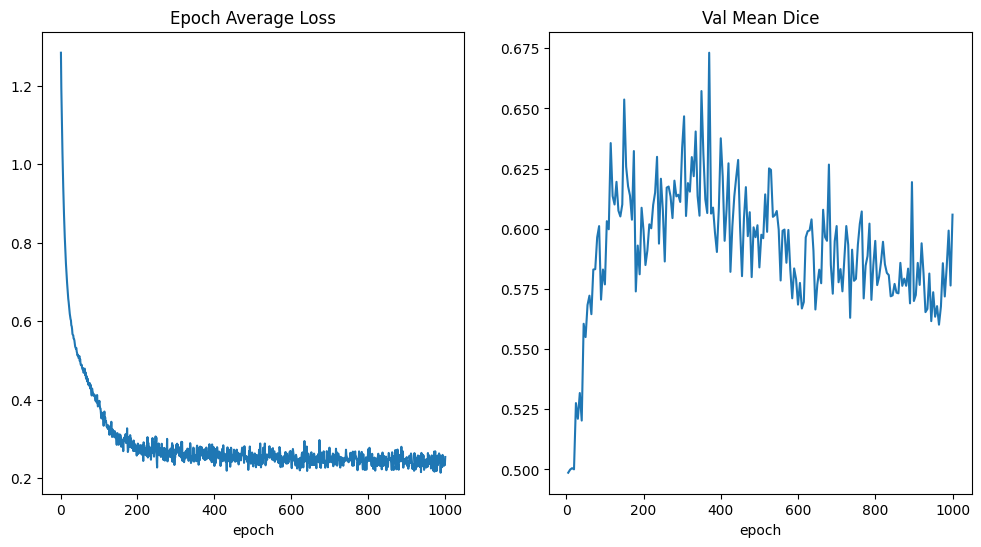

In [14]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [1]:
model.load_state_dict(torch.load(os.path.join("./", "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
        # plot the slice [:, :, 80]
        slice_idx = 155
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, slice_idx], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, slice_idx])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_idx])
        plt.show()
        if i == 2:
            break

NameError: name 'model' is not defined